install library yang dibutuhkan

In [ ]:
%pip install -r "../requirements.txt"

  Using cached kornia-0.8.1-py2.py3-none-any.whl.metadata (17 kB)
Using cached kornia-0.8.1-py2.py3-none-any.whl (1.1 MB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.3 MB 5.6 MB/s eta 0:00:01
   --------------------------- ------------ 1.6/2.3 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Import Library

Code untuk melakukan import library library yang dibutuhkan

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import kornia.augmentation as K
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import rasterio
import datetime
from tqdm import tqdm
import time
from PIL import Image
import csv
import random
import pandas as pd
import zipfile

# Data Preparation

Inisialisasi Class Mempersiapkan Dataset

In [4]:
class RandomAugmentation(nn.Module):
    def __init__(self):
        super().__init__()
        self.aug = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            K.RandomVerticalFlip(p=0.5),
            K.RandomRotation(degrees=(0, 360), p=0.5, resample="bilinear")
        )

    def forward(self, image, mask):
        # image: Tensor [C, H, W], mask: Tensor [H, W]
        image = image.unsqueeze(0)  # -> [1, C, H, W]
        mask  = mask.unsqueeze(0).unsqueeze(0).float()  # -> [1, 1, H, W]

        # Apply same transformation to both
        out = self.aug(torch.cat([image, mask], dim=1))  # [1, C+1, H, W]

        image_aug = out[:, :-1, :, :].squeeze(0)  # [C, H, W]
        mask_aug = out[:, -1, :, :].squeeze(0).long()  # [H, W]

        return image_aug, mask_aug

In [5]:
# ========== 2. Dataset ==========
class SatelliteDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
        self.masks  = sorted([f for f in os.listdir(mask_dir)  if f.endswith(".png")])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Read 16-bit image with rasterio
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32) / 65535.0  # normalize

        image = torch.from_numpy(image).float()  # (C, H, W)

        # Load 8-bit mask
        mask = np.array(Image.open(mask_path))
        mask = torch.tensor(mask, dtype=torch.long)  # (H, W)

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

Load Dataset

In [22]:
image_dir = "dataset/dataset_16bit"
mask_dir = "dataset/label_index"

# Validasi apakah folder benar-benar ada
assert os.path.exists(image_dir), f"Folder gambar tidak ditemukan: {image_dir}"
assert os.path.exists(mask_dir), f"Folder label tidak ditemukan: {mask_dir}"

print("✅ Path valid. Siap melanjutkan...")

✅ Path valid. Siap melanjutkan...


Train 80, Validation 20

In [23]:
# ========== 3. Data Preparation ==========
full_dataset = SatelliteDataset(image_dir, mask_dir)

batch_size = 16

# Split 80% train, 20% validation
total_size = len(full_dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

# Ganti transform hanya pada train_dataset
train_dataset.dataset.transform = RandomAugmentation()  # assign transform to dataset inside Subset

# ========== 4. DataLoaders ==========
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [24]:
print("Jumlah data latih:", len(train_dataset))
print("Jumlah data validation  :", len(val_dataset))

Jumlah data latih: 8100
Jumlah data validation  : 2025


In [25]:
print("Total dataset:", len(SatelliteDataset(image_dir, mask_dir)))

Total dataset: 10125


# Modeling

SK-ResNeXt50 Encoder Code

In [26]:
class SKConv(nn.Module):
    def __init__(self, channels, stride=1, groups=32, reduction=16):
        super(SKConv, self).__init__()
        d = max(channels // reduction, 4)

        # Two separate convolutional branches
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(channels)

        self.conv5 = nn.Conv2d(channels, channels, kernel_size=3, stride=stride, padding=2, dilation=2, groups=groups, bias=False)
        self.bn5 = nn.BatchNorm2d(channels)

        self.relu = nn.ReLU(inplace=True)

        # Squeeze-and-Excitation (SK attention)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, d, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(d, channels * 2, kernel_size=1, bias=False)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x3 = self.relu(self.bn3(self.conv3(x)))  # branch 1
        x5 = self.relu(self.bn5(self.conv5(x)))  # branch 2

        feats = torch.stack([x3, x5], dim=1)  # shape: (B, 2, C, H, W)

        # Fuse
        u = x3 + x5
        s = self.global_pool(u)
        z = self.fc1(s)
        a_b = self.fc2(z).view(x.size(0), 2, x.size(1), 1, 1)  # shape: (B, 2, C, 1, 1)
        a_b = self.softmax(a_b)

        out = (feats * a_b).sum(dim=1)
        return out


class resnext_block(nn.Module):
    def __init__(self, in_channels, cardinality, bwidth, idt_downsample=None, stride=1):
        super(resnext_block, self).__init__()
        self.expansion = 2
        out_channels = cardinality * bwidth

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Replaced conv2 with SKConv
        self.skconv = SKConv(out_channels, stride=stride, groups=cardinality)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.identity_downsample = idt_downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.skconv(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        out += identity
        out = self.relu(out)
        return out

# == SKResNeXt50 Encoder ==
class SKResNeXt(nn.Module):
    def __init__(self, resnet_block, layers, cardinality, bwidth, img_channels, num_classes):
        super(SKResNeXt, self).__init__()
        self.in_channels = 64
        self.cardinality = cardinality
        self.bwidth = bwidth

        self.stem = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._layers(resnet_block, layers[0], stride=1)
        self.layer2 = self._layers(resnet_block, layers[1], stride=2)
        self.layer3 = self._layers(resnet_block, layers[2], stride=2)
        self.layer4 = self._layers(resnet_block, layers[3], stride=2)

    def forward(self, x):
        x0 = self.stem(x)
        x0p = self.maxpool(x0)
        x1 = self.layer1(x0p)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        return x0, x1, x2, x3, x4

    def _layers(self, block, blocks, stride):
        identity_downsample = None
        out_channels = self.cardinality * self.bwidth
        layers = []

        if stride != 1 or self.in_channels != out_channels * 2:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 2, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 2)
            )

        layers.append(block(self.in_channels, self.cardinality, self.bwidth, identity_downsample, stride))
        self.in_channels = out_channels * 2

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, self.cardinality, self.bwidth))

        self.bwidth *= 2
        return nn.Sequential(*layers)

def SKResNeXt50(img_channels=4, num_classes=6, cardinality=32, bwidth=4):
    return SKResNeXt(resnext_block, [3, 4, 6, 3], cardinality, bwidth, img_channels, num_classes)

U-Net SK-ResNeXt50 Baseline

In [27]:
class UNet_SKResNeXt50(nn.Module):
    def __init__(self, in_channels=4, out_channels=6, cardinality=32, bwidth=4):
        super(UNet_SKResNeXt50, self).__init__()
        self.encoder = SKResNeXt50(img_channels=in_channels, num_classes=out_channels, cardinality=cardinality, bwidth=bwidth)

        # Decoder
        self.expansion_filter = (cardinality * bwidth) * 2

        self.up1 = nn.ConvTranspose2d(self.expansion_filter*8, self.expansion_filter*4, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(self.expansion_filter*8, self.expansion_filter*4)  # 1024 + skip 1024

        self.up2 = nn.ConvTranspose2d(self.expansion_filter*4, self.expansion_filter*2, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(self.expansion_filter*4, self.expansion_filter*2)   # 512 + skip 512

        self.up3 = nn.ConvTranspose2d(self.expansion_filter*2, self.expansion_filter, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(self.expansion_filter*2, self.expansion_filter)    # 256 + skip 256

        self.up4 = nn.ConvTranspose2d(self.expansion_filter, 128, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(128 + 64, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)


    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        x0, x1, x2, x3, x4 = self.encoder(x)

        # Decoder
        d1 = self.up1(x4)
        d1 = self.dec1(torch.cat([d1, x3], dim=1))

        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, x2], dim=1))

        d3 = self.up3(d2)
        d3 = self.dec3(torch.cat([d3, x1], dim=1))

        d4 = self.up4(d3)
        d4 = self.dec4(torch.cat([d4, x0], dim=1))

        out =  self.out_conv(d4)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)
        return out

# Train

In [28]:
def pixel_accuracy(output, mask):
    """
    Menghitung pixel-wise accuracy untuk semantic segmentation.

    Args:
        output (torch.Tensor): Output dari model, shape (B, C, H, W)
        mask (torch.Tensor): Ground truth label, shape (B, H, W)

    Returns:
        float: Pixel accuracy (%)
    """
    # Ambil prediksi kelas (argmax di dimensi channel)
    preds = torch.argmax(output, dim=1)  # shape: (B, H, W)

    # Hitung jumlah piksel yang benar
    correct = (preds == mask).float().sum()
    total = mask.numel()

    return (correct / total).item() * 100

In [29]:
def evaluate(model, val_loader, device, criterion):
    model.eval()
    total_acc = 0
    total_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            acc = pixel_accuracy(outputs, masks)

            total_loss += loss.item()
            total_acc += acc

    avg_loss = total_loss / len(val_loader)
    avg_acc = total_acc / len(val_loader)
    return avg_loss, avg_acc

In [30]:
# ========== Cek & Load Checkpoint ==========
def get_latest_checkpoint(checkpoint_dir):
    if not os.path.exists(checkpoint_dir):
        return None
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
    if not checkpoints:
        return None
    checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    return os.path.join(checkpoint_dir, checkpoints[-1])

In [31]:
# ========== 3. Training Setup ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = UNet_SKResNeXt50(in_channels=4, out_channels=6, cardinality=32, bwidth=4).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 120

Device: cuda


Model Spesification

In [32]:
model.eval()

UNet_SKResNeXt50(
  (encoder): SKResNeXt(
    (stem): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): resnext_block(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (skconv): SKConv(
          (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), groups=32, bias=False)
          (bn5): BatchNorm2d(128, eps=1e

In [33]:
# Hitung total parameters model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

73809414

**Training**

Inisialisasi Output Path

In [34]:
# Define name of folder output main path

output_path = "baseline_32x4d" #JANGAN LUPA GANTI INI

Output path

In [ ]:
# Paths
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
last_model_path = f"output/{output_path}/last_model/unet_skresnext50_baseline_last.pt"
best_model_path = f"output/{output_path}/best_model/unet_skresnext50_baseline_best.pt"
checkpoint_dir = f"output/{output_path}/checkpoint"
log_dir = f"output/{output_path}/logs"
log_path = os.path.join(log_dir, f"training_log_{timestamp}.txt")
csv_path = os.path.join(log_dir, "trainlog.csv")
csv_path_resume = os.path.join(log_dir, "trainlog_resume.csv")
diagram_dir = f"output/{output_path}/diagram"
inference_dir = f"output/{output_path}/inference"

# Ensure directories exist
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
os.makedirs(os.path.dirname(last_model_path), exist_ok=True)
os.makedirs(diagram_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(inference_dir, exist_ok=True)

Inisialisasi Logging

In [39]:
log_lines = []
log_lines.append(f"🕒 Training Started: {timestamp}")
log_lines.append(f"Best Model Path: {best_model_path}")
log_lines.append(f"Checkpoint Directory: {checkpoint_dir}")
log_lines.append("")

Inisialisasi History Untuk Plot Diagram Garis Train dan Val

In [40]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

Training Loop

In [ ]:
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, masks in train_pbar:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        acc = pixel_accuracy(outputs, masks)
        epoch_loss += loss.item()
        epoch_acc += acc

        train_pbar.set_postfix(loss=loss.item(), acc=acc)
        log_lines.append(f"Epoch {epoch+1} | Loss: {loss.item():.4f}, Acc: {acc:.2f}%")

    val_loss, val_acc = evaluate(model, val_loader, device, criterion)

    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(epoch_acc / len(train_loader))
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])
        for i in range(len(train_losses)):
            writer.writerow([
                i + 1,
                train_losses[i],
                train_accuracies[i],
                val_losses[i],
                val_accuracies[i]
            ])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Model disimpan (Val Loss: {val_loss:.4f})")
        log_lines.append(f"✅ Model disimpan (Val Loss: {val_loss:.4f}) [Epoch {epoch+1}]")

    if (epoch + 1) % 20 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'best_val_loss': best_val_loss
        }, checkpoint_path)
        print(f"💾 Checkpoint disimpan: {checkpoint_path}")
        log_lines.append(f"💾 Checkpoint disimpan: {checkpoint_path}")

    log_line = f"Epoch {epoch+1} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
    print(log_line)
    log_lines.append(log_line)

with open(log_path, "w") as f:
    f.write("\n".join(log_lines))
print(f"\n📄 Log training disimpan di: {log_path}")

torch.save(model.state_dict(), last_model_path)
print(f"📦 Model terakhir disimpan di: {last_model_path}")

Epoch 1/120: 100%|██████████| 507/507 [03:25<00:00,  2.46it/s, acc=64.9, loss=0.755]


✅ Model disimpan (Val Loss: 1.0239)
Epoch 1 | Val Loss: 1.0239 | Val Acc: 61.45%


Epoch 2/120: 100%|██████████| 507/507 [03:26<00:00,  2.46it/s, acc=62.8, loss=0.864]


✅ Model disimpan (Val Loss: 0.6842)
Epoch 2 | Val Loss: 0.6842 | Val Acc: 73.70%


Epoch 3/120: 100%|██████████| 507/507 [03:25<00:00,  2.46it/s, acc=55.2, loss=1.05]


Epoch 3 | Val Loss: 0.9714 | Val Acc: 64.65%


Epoch 4/120: 100%|██████████| 507/507 [03:25<00:00,  2.46it/s, acc=56.7, loss=0.913]


Epoch 4 | Val Loss: 0.7026 | Val Acc: 71.98%


Epoch 5/120: 100%|██████████| 507/507 [03:25<00:00,  2.47it/s, acc=61.8, loss=0.809]


Epoch 5 | Val Loss: 0.7397 | Val Acc: 72.14%


Epoch 6/120: 100%|██████████| 507/507 [03:25<00:00,  2.47it/s, acc=67.2, loss=0.98]


✅ Model disimpan (Val Loss: 0.6238)
Epoch 6 | Val Loss: 0.6238 | Val Acc: 75.62%


Epoch 7/120: 100%|██████████| 507/507 [03:25<00:00,  2.47it/s, acc=73.4, loss=0.708]


✅ Model disimpan (Val Loss: 0.5921)
Epoch 7 | Val Loss: 0.5921 | Val Acc: 77.15%


Epoch 8/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=59.7, loss=1.06]


Epoch 8 | Val Loss: 0.6036 | Val Acc: 76.62%


Epoch 9/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=62.6, loss=0.823]


✅ Model disimpan (Val Loss: 0.5822)
Epoch 9 | Val Loss: 0.5822 | Val Acc: 77.31%


Epoch 10/120: 100%|██████████| 507/507 [03:24<00:00,  2.47it/s, acc=77.5, loss=0.738]


Epoch 10 | Val Loss: 0.7831 | Val Acc: 70.35%


Epoch 11/120: 100%|██████████| 507/507 [03:24<00:00,  2.47it/s, acc=61.2, loss=1.36]


✅ Model disimpan (Val Loss: 0.5465)
Epoch 11 | Val Loss: 0.5465 | Val Acc: 78.35%


Epoch 12/120: 100%|██████████| 507/507 [03:25<00:00,  2.47it/s, acc=71.8, loss=0.727]


Epoch 12 | Val Loss: 0.5984 | Val Acc: 76.58%


Epoch 13/120: 100%|██████████| 507/507 [03:25<00:00,  2.47it/s, acc=72, loss=0.701]


Epoch 13 | Val Loss: 0.7804 | Val Acc: 71.39%


Epoch 14/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=72.9, loss=0.667]


Epoch 14 | Val Loss: 0.5489 | Val Acc: 78.50%


Epoch 15/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=72.1, loss=0.765]


Epoch 15 | Val Loss: 0.8400 | Val Acc: 70.41%


Epoch 16/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=76.1, loss=0.585]


✅ Model disimpan (Val Loss: 0.5432)
Epoch 16 | Val Loss: 0.5432 | Val Acc: 78.42%


Epoch 17/120: 100%|██████████| 507/507 [03:25<00:00,  2.47it/s, acc=84.2, loss=0.561]


Epoch 17 | Val Loss: 0.6566 | Val Acc: 75.32%


Epoch 18/120: 100%|██████████| 507/507 [03:24<00:00,  2.47it/s, acc=86.5, loss=0.404]


Epoch 18 | Val Loss: 0.5478 | Val Acc: 78.68%


Epoch 19/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=60.2, loss=0.896]


✅ Model disimpan (Val Loss: 0.5259)
Epoch 19 | Val Loss: 0.5259 | Val Acc: 79.37%


Epoch 20/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=68.3, loss=0.792]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_8x14d_run2/checkpoint/checkpoint_epoch_20.pth
Epoch 20 | Val Loss: 0.5470 | Val Acc: 78.60%


Epoch 21/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=85.6, loss=0.357]


Epoch 21 | Val Loss: 0.5306 | Val Acc: 79.90%


Epoch 22/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=76.2, loss=0.612]


✅ Model disimpan (Val Loss: 0.5035)
Epoch 22 | Val Loss: 0.5035 | Val Acc: 80.38%


Epoch 23/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=59.1, loss=1.03]


Epoch 23 | Val Loss: 0.5127 | Val Acc: 79.76%


Epoch 24/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=75.7, loss=0.623]


Epoch 24 | Val Loss: 0.5129 | Val Acc: 80.27%


Epoch 25/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=76.2, loss=0.691]


Epoch 25 | Val Loss: 0.5195 | Val Acc: 79.44%


Epoch 26/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=68.5, loss=0.731]


Epoch 26 | Val Loss: 0.5220 | Val Acc: 79.77%


Epoch 27/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=78, loss=0.599]


✅ Model disimpan (Val Loss: 0.4682)
Epoch 27 | Val Loss: 0.4682 | Val Acc: 81.72%


Epoch 28/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=76.3, loss=0.802]


Epoch 28 | Val Loss: 0.5416 | Val Acc: 78.83%


Epoch 29/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=71.4, loss=0.736]


Epoch 29 | Val Loss: 0.5577 | Val Acc: 78.23%


Epoch 30/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=79.2, loss=0.534]


Epoch 30 | Val Loss: 0.4892 | Val Acc: 80.68%


Epoch 31/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=77.6, loss=0.605]


✅ Model disimpan (Val Loss: 0.4662)
Epoch 31 | Val Loss: 0.4662 | Val Acc: 81.84%


Epoch 32/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=79.8, loss=0.477]


Epoch 32 | Val Loss: 0.5248 | Val Acc: 79.95%


Epoch 33/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=89.3, loss=0.323]


Epoch 33 | Val Loss: 0.5088 | Val Acc: 80.01%


Epoch 34/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=85.2, loss=0.367]


Epoch 34 | Val Loss: 0.5629 | Val Acc: 77.92%


Epoch 35/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=84.7, loss=0.498]


Epoch 35 | Val Loss: 0.4935 | Val Acc: 81.09%


Epoch 36/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=53.6, loss=1.19]


Epoch 36 | Val Loss: 0.4743 | Val Acc: 81.78%


Epoch 37/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=85.6, loss=0.337]


Epoch 37 | Val Loss: 0.4677 | Val Acc: 82.02%


Epoch 38/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=76.2, loss=0.582]


Epoch 38 | Val Loss: 0.5117 | Val Acc: 80.62%


Epoch 39/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=60.2, loss=1]


Epoch 39 | Val Loss: 0.5330 | Val Acc: 79.34%


Epoch 40/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=56.2, loss=1.19]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_8x14d_run2/checkpoint/checkpoint_epoch_40.pth
Epoch 40 | Val Loss: 0.4972 | Val Acc: 80.39%


Epoch 41/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=83.4, loss=0.445]


Epoch 41 | Val Loss: 0.7723 | Val Acc: 72.78%


Epoch 42/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=72.8, loss=0.647]


Epoch 42 | Val Loss: 0.4821 | Val Acc: 80.97%


Epoch 43/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=86.7, loss=0.37]


Epoch 43 | Val Loss: 0.5017 | Val Acc: 80.17%


Epoch 44/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=77.5, loss=0.519]


✅ Model disimpan (Val Loss: 0.4507)
Epoch 44 | Val Loss: 0.4507 | Val Acc: 82.16%


Epoch 45/120: 100%|██████████| 507/507 [03:24<00:00,  2.49it/s, acc=72.9, loss=0.648]


Epoch 45 | Val Loss: 0.4584 | Val Acc: 82.10%


Epoch 46/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=73.6, loss=0.638]


Epoch 46 | Val Loss: 0.4638 | Val Acc: 82.26%


Epoch 47/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=81.4, loss=0.51]


✅ Model disimpan (Val Loss: 0.4312)
Epoch 47 | Val Loss: 0.4312 | Val Acc: 83.30%


Epoch 48/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=89, loss=0.312]


Epoch 48 | Val Loss: 0.4953 | Val Acc: 80.45%


Epoch 49/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=90.5, loss=0.245]


Epoch 49 | Val Loss: 0.4377 | Val Acc: 82.82%


Epoch 50/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=77.3, loss=0.589]


Epoch 50 | Val Loss: 0.4373 | Val Acc: 82.73%


Epoch 51/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=80, loss=0.541]


Epoch 51 | Val Loss: 0.4446 | Val Acc: 82.35%


Epoch 52/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=79.1, loss=0.531]


Epoch 52 | Val Loss: 0.4656 | Val Acc: 81.88%


Epoch 53/120: 100%|██████████| 507/507 [03:24<00:00,  2.48it/s, acc=74.7, loss=0.706]


Epoch 53 | Val Loss: 0.4532 | Val Acc: 82.09%


Epoch 54/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=68.6, loss=0.796]


Epoch 54 | Val Loss: 0.4678 | Val Acc: 81.53%


Epoch 55/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=73.2, loss=0.73]


Epoch 55 | Val Loss: 0.4815 | Val Acc: 81.13%


Epoch 56/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=47.8, loss=1.64]


Epoch 56 | Val Loss: 0.6752 | Val Acc: 75.29%


Epoch 57/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=78.8, loss=0.518]


Epoch 57 | Val Loss: 0.4556 | Val Acc: 82.06%


Epoch 58/120: 100%|██████████| 507/507 [03:24<00:00,  2.49it/s, acc=68.9, loss=0.806]


Epoch 58 | Val Loss: 0.4392 | Val Acc: 82.93%


Epoch 59/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=74.7, loss=0.612]


Epoch 59 | Val Loss: 0.4481 | Val Acc: 82.34%


Epoch 60/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=76.2, loss=0.656]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_8x14d_run2/checkpoint/checkpoint_epoch_60.pth
Epoch 60 | Val Loss: 0.4357 | Val Acc: 83.02%


Epoch 61/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=78.7, loss=0.452]


Epoch 61 | Val Loss: 0.4571 | Val Acc: 82.41%


Epoch 62/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=81.8, loss=0.487]


Epoch 62 | Val Loss: 0.4543 | Val Acc: 82.31%


Epoch 63/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=77.9, loss=0.559]


Epoch 63 | Val Loss: 0.4613 | Val Acc: 82.25%


Epoch 64/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=75, loss=0.698]


✅ Model disimpan (Val Loss: 0.4296)
Epoch 64 | Val Loss: 0.4296 | Val Acc: 83.24%


Epoch 65/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=77.7, loss=0.543]


Epoch 65 | Val Loss: 0.6118 | Val Acc: 77.18%


Epoch 66/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=87.1, loss=0.364]


Epoch 66 | Val Loss: 0.4330 | Val Acc: 83.02%


Epoch 67/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=80.3, loss=0.557]


Epoch 67 | Val Loss: 0.4499 | Val Acc: 82.61%


Epoch 68/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=76.7, loss=0.603]


Epoch 68 | Val Loss: 0.4374 | Val Acc: 83.20%


Epoch 69/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=85.3, loss=0.392]


Epoch 69 | Val Loss: 0.4390 | Val Acc: 83.03%


Epoch 70/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=75.8, loss=0.593]


✅ Model disimpan (Val Loss: 0.4164)
Epoch 70 | Val Loss: 0.4164 | Val Acc: 83.62%


Epoch 71/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=78.1, loss=0.531]


Epoch 71 | Val Loss: 0.4288 | Val Acc: 83.37%


Epoch 72/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=77.7, loss=0.611]


Epoch 72 | Val Loss: 0.4384 | Val Acc: 82.88%


Epoch 73/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=71.8, loss=0.781]


Epoch 73 | Val Loss: 0.4402 | Val Acc: 82.66%


Epoch 74/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=75.9, loss=0.554]


Epoch 74 | Val Loss: 0.4502 | Val Acc: 82.58%


Epoch 75/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=83.2, loss=0.518]


Epoch 75 | Val Loss: 0.4792 | Val Acc: 81.61%


Epoch 76/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=73.2, loss=0.638]


Epoch 76 | Val Loss: 0.5473 | Val Acc: 79.46%


Epoch 77/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=87.2, loss=0.355]


Epoch 77 | Val Loss: 0.4378 | Val Acc: 83.12%


Epoch 78/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=77.8, loss=0.545]


Epoch 78 | Val Loss: 0.4856 | Val Acc: 80.97%


Epoch 79/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=57.8, loss=0.961]


Epoch 79 | Val Loss: 0.4581 | Val Acc: 82.08%


Epoch 80/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=84.8, loss=0.423]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_8x14d_run2/checkpoint/checkpoint_epoch_80.pth
Epoch 80 | Val Loss: 0.4301 | Val Acc: 83.34%


Epoch 81/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=60.7, loss=1.34]


Epoch 81 | Val Loss: 0.4469 | Val Acc: 82.53%


Epoch 82/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=87.1, loss=0.401]


Epoch 82 | Val Loss: 0.4454 | Val Acc: 82.72%


Epoch 83/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=85, loss=0.375]


Epoch 83 | Val Loss: 0.4648 | Val Acc: 82.00%


Epoch 84/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=87.9, loss=0.401]


Epoch 84 | Val Loss: 0.4280 | Val Acc: 83.15%


Epoch 85/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=67.4, loss=0.895]


Epoch 85 | Val Loss: 0.4583 | Val Acc: 82.55%


Epoch 86/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=89.4, loss=0.351]


✅ Model disimpan (Val Loss: 0.4128)
Epoch 86 | Val Loss: 0.4128 | Val Acc: 83.94%


Epoch 87/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=76.2, loss=0.795]


Epoch 87 | Val Loss: 0.8082 | Val Acc: 73.30%


Epoch 88/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=81, loss=0.476]


Epoch 88 | Val Loss: 0.4411 | Val Acc: 82.77%


Epoch 89/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=77.4, loss=0.503]


Epoch 89 | Val Loss: 0.4747 | Val Acc: 81.58%


Epoch 90/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=78.3, loss=0.55]


Epoch 90 | Val Loss: 0.4251 | Val Acc: 83.37%


Epoch 91/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=88.9, loss=0.311]


Epoch 91 | Val Loss: 0.4429 | Val Acc: 82.78%


Epoch 92/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=79.8, loss=0.491]


Epoch 92 | Val Loss: 0.4898 | Val Acc: 81.10%


Epoch 93/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=90.7, loss=0.314]


Epoch 93 | Val Loss: 0.5106 | Val Acc: 80.54%


Epoch 94/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=83.4, loss=0.418]


Epoch 94 | Val Loss: 0.4139 | Val Acc: 83.89%


Epoch 95/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=88.3, loss=0.353]


Epoch 95 | Val Loss: 0.4212 | Val Acc: 83.73%


Epoch 96/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=83, loss=0.398]


Epoch 96 | Val Loss: 0.4279 | Val Acc: 83.50%


Epoch 97/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=82.1, loss=0.475]


Epoch 97 | Val Loss: 0.4507 | Val Acc: 82.88%


Epoch 98/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=86.7, loss=0.357]


Epoch 98 | Val Loss: 0.4642 | Val Acc: 81.88%


Epoch 99/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=87.1, loss=0.31]


Epoch 99 | Val Loss: 0.4230 | Val Acc: 83.93%


Epoch 100/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=79.6, loss=0.604]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_8x14d_run2/checkpoint/checkpoint_epoch_100.pth
Epoch 100 | Val Loss: 0.4680 | Val Acc: 82.04%


Epoch 101/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=74.8, loss=0.586]


✅ Model disimpan (Val Loss: 0.4110)
Epoch 101 | Val Loss: 0.4110 | Val Acc: 83.92%


Epoch 102/120: 100%|██████████| 507/507 [03:23<00:00,  2.50it/s, acc=82.6, loss=0.386]


Epoch 102 | Val Loss: 0.4371 | Val Acc: 83.17%


Epoch 103/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=85.3, loss=0.382]


Epoch 103 | Val Loss: 0.4445 | Val Acc: 83.06%


Epoch 104/120: 100%|██████████| 507/507 [03:22<00:00,  2.51it/s, acc=84.9, loss=0.37]


Epoch 104 | Val Loss: 0.4438 | Val Acc: 82.85%


Epoch 105/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=82.2, loss=0.455]


Epoch 105 | Val Loss: 0.4240 | Val Acc: 83.53%


Epoch 106/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=86.2, loss=0.398]


Epoch 106 | Val Loss: 0.4272 | Val Acc: 83.68%


Epoch 107/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=82.1, loss=0.457]


Epoch 107 | Val Loss: 0.4352 | Val Acc: 83.53%


Epoch 108/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=86.6, loss=0.367]


✅ Model disimpan (Val Loss: 0.4100)
Epoch 108 | Val Loss: 0.4100 | Val Acc: 83.97%


Epoch 109/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=86.2, loss=0.358]


Epoch 109 | Val Loss: 0.4343 | Val Acc: 83.17%


Epoch 110/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=77.2, loss=0.526]


Epoch 110 | Val Loss: 0.4181 | Val Acc: 83.64%


Epoch 111/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=77.9, loss=0.554]


Epoch 111 | Val Loss: 0.4886 | Val Acc: 81.84%


Epoch 112/120: 100%|██████████| 507/507 [03:23<00:00,  2.49it/s, acc=85.7, loss=0.386]


Epoch 112 | Val Loss: 0.4217 | Val Acc: 83.45%


Epoch 113/120: 100%|██████████| 507/507 [03:22<00:00,  2.51it/s, acc=59.8, loss=1.08]


Epoch 113 | Val Loss: 0.4895 | Val Acc: 81.20%


Epoch 114/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=76.5, loss=0.534]


Epoch 114 | Val Loss: 0.4231 | Val Acc: 83.49%


Epoch 115/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=75.2, loss=0.547]


✅ Model disimpan (Val Loss: 0.3981)
Epoch 115 | Val Loss: 0.3981 | Val Acc: 84.59%


Epoch 116/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=79.5, loss=0.483]


Epoch 116 | Val Loss: 0.4236 | Val Acc: 83.71%


Epoch 117/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=68.6, loss=0.741]


Epoch 117 | Val Loss: 0.4327 | Val Acc: 83.44%


Epoch 118/120: 100%|██████████| 507/507 [03:22<00:00,  2.50it/s, acc=79.4, loss=0.56]


Epoch 118 | Val Loss: 0.4125 | Val Acc: 83.94%


Epoch 119/120: 100%|██████████| 507/507 [03:22<00:00,  2.51it/s, acc=85.5, loss=0.398]


Epoch 119 | Val Loss: 0.4412 | Val Acc: 83.36%


Epoch 120/120: 100%|██████████| 507/507 [03:22<00:00,  2.51it/s, acc=79.3, loss=0.517]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_8x14d_run2/checkpoint/checkpoint_epoch_120.pth
Epoch 120 | Val Loss: 0.4187 | Val Acc: 83.97%

📄 Log training disimpan di: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_8x14d_run2/logs/training_log_20250622_144401.txt
📦 Model terakhir disimpan di: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_8x14d_run2/last_model/unet_skresnext50_baseline_last.pt


In [ ]:
latest_checkpoint_path = get_latest_checkpoint(checkpoint_dir)
best_val_loss = float('inf')
start_epoch = 0

if latest_checkpoint_path:
    print(f"🔄 Melanjutkan training dari checkpoint: {latest_checkpoint_path}")
    checkpoint = torch.load(latest_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))

for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss, epoch_acc = 0.0, 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, masks in pbar:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        acc = pixel_accuracy(outputs, masks)
        epoch_loss += loss.item()
        epoch_acc += acc

        pbar.set_postfix(loss=loss.item(), acc=acc)

    # === Validasi ===
    val_loss, val_acc = evaluate(model, val_loader, device, criterion)  # Asumsinya juga % dari evaluate()

    # === Simpan history ke list ===
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(epoch_acc / len(train_loader))
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # === Simpan ke CSV ===
    with open(csv_path_resume, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Train Accuracy (%)", "Val Loss", "Val Accuracy (%)"])
        for i in range(len(train_losses)):
            writer.writerow([
                start_epoch + i + 1,
                train_losses[i],
                train_accuracies[i],
                val_losses[i],
                val_accuracies[i]
            ])

    # === Simpan Best Model ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model updated at epoch {epoch+1}")
        log_lines.append(f"✅ Best model updated at epoch {epoch+1} | Val Loss: {val_loss:.4f}")

    # === Simpan Checkpoint setiap 10 epoch ===
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss
        }, checkpoint_path)
        print(f"💾 Checkpoint disimpan: {checkpoint_path}")

    # === Logging ke terminal dan log_lines ===
    avg_train_loss = epoch_loss / len(train_loader)
    avg_train_acc = epoch_acc / len(train_loader)

    log_line = f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%"
    print(log_line)
    log_lines.append(log_line)

# ========== Simpan Model Terakhir ==========
torch.save(model.state_dict(), last_model_path)
print(f"📦 Model terakhir disimpan: {last_model_path}")

# ========== Simpan Log ke TXT ==========
with open(log_path, "w") as f:
    f.write("\n".join(log_lines))
print(f"📝 Log disimpan: {log_path}")


🔄 Melanjutkan training dari checkpoint: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_32x4d_run2/checkpoint/checkpoint_epoch_80.pth


Epoch 81/120: 100%|██████████| 507/507 [03:43<00:00,  2.27it/s, acc=83.1, loss=0.491]


✅ Best model updated at epoch 81
Epoch 81 | Train Loss: 198.2319, Acc: 84.78% | Val Loss: 0.4173, Acc: 83.73%


Epoch 82/120: 100%|██████████| 507/507 [03:43<00:00,  2.27it/s, acc=91.1, loss=0.271]


Epoch 82 | Train Loss: 201.1796, Acc: 84.58% | Val Loss: 0.4370, Acc: 83.20%


Epoch 83/120: 100%|██████████| 507/507 [03:43<00:00,  2.27it/s, acc=78.1, loss=0.507]


✅ Best model updated at epoch 83
Epoch 83 | Train Loss: 198.3701, Acc: 84.76% | Val Loss: 0.4070, Acc: 84.03%


Epoch 84/120: 100%|██████████| 507/507 [03:43<00:00,  2.27it/s, acc=86.4, loss=0.356]


Epoch 84 | Train Loss: 198.5102, Acc: 84.79% | Val Loss: 0.4181, Acc: 83.81%


Epoch 85/120: 100%|██████████| 507/507 [03:43<00:00,  2.27it/s, acc=78.7, loss=0.516]


Epoch 85 | Train Loss: 196.8347, Acc: 84.84% | Val Loss: 0.4270, Acc: 83.15%


Epoch 86/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=76.8, loss=0.565]


Epoch 86 | Train Loss: 196.4968, Acc: 84.94% | Val Loss: 0.4255, Acc: 83.42%


Epoch 87/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=87.5, loss=0.373]


Epoch 87 | Train Loss: 198.1721, Acc: 84.77% | Val Loss: 0.4691, Acc: 81.93%


Epoch 88/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=77.9, loss=0.442]


Epoch 88 | Train Loss: 201.3830, Acc: 84.63% | Val Loss: 0.4489, Acc: 82.87%


Epoch 89/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=65.9, loss=0.755]


Epoch 89 | Train Loss: 196.2672, Acc: 84.88% | Val Loss: 0.4554, Acc: 82.26%


Epoch 90/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=85.5, loss=0.419]


Epoch 90 | Train Loss: 197.2522, Acc: 84.89% | Val Loss: 0.7216, Acc: 74.14%


Epoch 91/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=89.8, loss=0.301]


Epoch 91 | Train Loss: 194.4148, Acc: 85.08% | Val Loss: 0.4083, Acc: 84.14%


Epoch 92/120: 100%|██████████| 507/507 [03:43<00:00,  2.27it/s, acc=60.1, loss=1.12]


Epoch 92 | Train Loss: 195.3510, Acc: 85.03% | Val Loss: 0.4092, Acc: 84.04%


Epoch 93/120: 100%|██████████| 507/507 [03:43<00:00,  2.27it/s, acc=51.6, loss=1.03]


Epoch 93 | Train Loss: 197.5179, Acc: 84.81% | Val Loss: 0.4474, Acc: 82.91%


Epoch 94/120: 100%|██████████| 507/507 [03:43<00:00,  2.27it/s, acc=77.6, loss=0.535]


Epoch 94 | Train Loss: 194.8820, Acc: 85.02% | Val Loss: 0.4482, Acc: 82.78%


Epoch 95/120: 100%|██████████| 507/507 [03:43<00:00,  2.27it/s, acc=82.6, loss=0.454]


Epoch 95 | Train Loss: 194.5172, Acc: 85.06% | Val Loss: 0.4252, Acc: 83.57%


Epoch 96/120: 100%|██████████| 507/507 [03:44<00:00,  2.26it/s, acc=87, loss=0.394]


Epoch 96 | Train Loss: 195.4446, Acc: 84.97% | Val Loss: 0.4222, Acc: 83.49%


Epoch 97/120: 100%|██████████| 507/507 [03:44<00:00,  2.26it/s, acc=78.5, loss=0.512]


✅ Best model updated at epoch 97
Epoch 97 | Train Loss: 192.4832, Acc: 85.23% | Val Loss: 0.4000, Acc: 84.43%


Epoch 98/120: 100%|██████████| 507/507 [03:44<00:00,  2.26it/s, acc=82.5, loss=0.399]


Epoch 98 | Train Loss: 193.2153, Acc: 85.12% | Val Loss: 0.4623, Acc: 82.19%


Epoch 99/120: 100%|██████████| 507/507 [03:43<00:00,  2.27it/s, acc=76.6, loss=0.61]


Epoch 99 | Train Loss: 191.4321, Acc: 85.28% | Val Loss: 0.4143, Acc: 83.93%


Epoch 100/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=74, loss=0.744]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_32x4d_run2/checkpoint/checkpoint_epoch_100.pt
Epoch 100 | Train Loss: 190.9929, Acc: 85.30% | Val Loss: 0.4168, Acc: 83.57%


Epoch 101/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=75.7, loss=0.647]


Epoch 101 | Train Loss: 189.9422, Acc: 85.38% | Val Loss: 0.4238, Acc: 83.71%


Epoch 102/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=76.8, loss=0.733]


Epoch 102 | Train Loss: 189.6004, Acc: 85.43% | Val Loss: 0.4420, Acc: 82.77%


Epoch 103/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=88.8, loss=0.351]


✅ Best model updated at epoch 103
Epoch 103 | Train Loss: 193.4405, Acc: 85.20% | Val Loss: 0.3944, Acc: 84.64%


Epoch 104/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=86.2, loss=0.422]


Epoch 104 | Train Loss: 190.2577, Acc: 85.40% | Val Loss: 0.4116, Acc: 83.89%


Epoch 105/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=80.7, loss=0.528]


Epoch 105 | Train Loss: 189.6654, Acc: 85.36% | Val Loss: 0.4180, Acc: 83.86%


Epoch 106/120: 100%|██████████| 507/507 [03:42<00:00,  2.27it/s, acc=61.1, loss=0.69]


Epoch 106 | Train Loss: 189.7770, Acc: 85.37% | Val Loss: 0.4309, Acc: 83.34%


Epoch 107/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=73.5, loss=0.687]


Epoch 107 | Train Loss: 192.2653, Acc: 85.26% | Val Loss: 0.4178, Acc: 83.74%


Epoch 108/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=87.9, loss=0.326]


Epoch 108 | Train Loss: 191.7924, Acc: 85.29% | Val Loss: 0.4085, Acc: 83.89%


Epoch 109/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=80.4, loss=0.505]


Epoch 109 | Train Loss: 188.8096, Acc: 85.48% | Val Loss: 0.4288, Acc: 83.29%


Epoch 110/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=83.7, loss=0.466]


Epoch 110 | Train Loss: 190.1241, Acc: 85.36% | Val Loss: 0.4192, Acc: 83.70%


Epoch 111/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=70, loss=0.632]


Epoch 111 | Train Loss: 187.6943, Acc: 85.55% | Val Loss: 0.4078, Acc: 83.86%


Epoch 112/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=89.1, loss=0.321]


Epoch 112 | Train Loss: 187.3490, Acc: 85.61% | Val Loss: 0.4274, Acc: 83.56%


Epoch 113/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=84, loss=0.426]


Epoch 113 | Train Loss: 185.9281, Acc: 85.67% | Val Loss: 0.4003, Acc: 84.43%


Epoch 114/120: 100%|██████████| 507/507 [03:43<00:00,  2.27it/s, acc=81.4, loss=0.465]


Epoch 114 | Train Loss: 186.8926, Acc: 85.61% | Val Loss: 0.4282, Acc: 83.35%


Epoch 115/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=80.6, loss=0.559]


Epoch 115 | Train Loss: 188.5484, Acc: 85.51% | Val Loss: 0.4402, Acc: 83.08%


Epoch 116/120: 100%|██████████| 507/507 [03:42<00:00,  2.28it/s, acc=64.1, loss=0.925]


Epoch 116 | Train Loss: 185.8322, Acc: 85.68% | Val Loss: 0.4177, Acc: 83.94%


Epoch 117/120: 100%|██████████| 507/507 [03:42<00:00,  2.27it/s, acc=65.4, loss=0.867]


Epoch 117 | Train Loss: 187.3140, Acc: 85.57% | Val Loss: 0.4391, Acc: 83.27%


Epoch 118/120: 100%|██████████| 507/507 [03:42<00:00,  2.27it/s, acc=83.8, loss=0.455]


Epoch 118 | Train Loss: 187.2087, Acc: 85.62% | Val Loss: 0.4079, Acc: 84.29%


Epoch 119/120: 100%|██████████| 507/507 [03:44<00:00,  2.26it/s, acc=88.7, loss=0.36]


Epoch 119 | Train Loss: 186.9350, Acc: 85.66% | Val Loss: 0.4219, Acc: 83.73%


Epoch 120/120: 100%|██████████| 507/507 [03:44<00:00,  2.26it/s, acc=65.3, loss=0.85]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_32x4d_run2/checkpoint/checkpoint_epoch_120.pt
Epoch 120 | Train Loss: 185.6096, Acc: 85.69% | Val Loss: 0.4248, Acc: 83.31%
📦 Model terakhir disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_32x4d_run2/last_model/unet_skresnext50_baseline_last.pt
📝 Log disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/baseline_32x4d_run2/logs/training_log_20250618_215759.txt


Load Model

In [41]:
# Load Model GPU
model.load_state_dict(torch.load(best_model_path))

# Load Model CPU
# model.load_state_dict(torch.load(last_model_path, map_location=torch.device('cpu')))

model.eval()

UNet_SKResNeXt50(
  (encoder): SKResNeXt(
    (stem): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): resnext_block(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (skconv): SKConv(
          (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), groups=32, bias=False)
          (bn5): BatchNorm2d(128, eps=1e

# Evaluasi Model

#### Plot Loss and Plot Akurasi dari variabel history train

Plot Loss

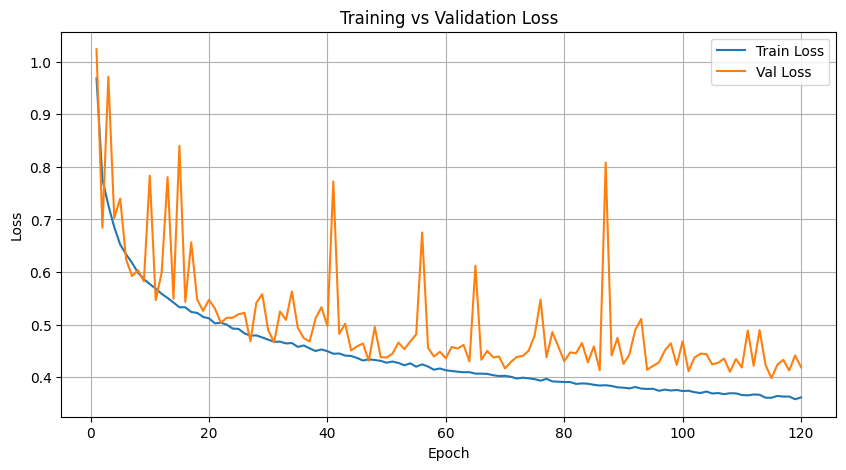

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'output/{output_path}/diagram/loss_plot.png')
plt.show()

Plot Accuracy

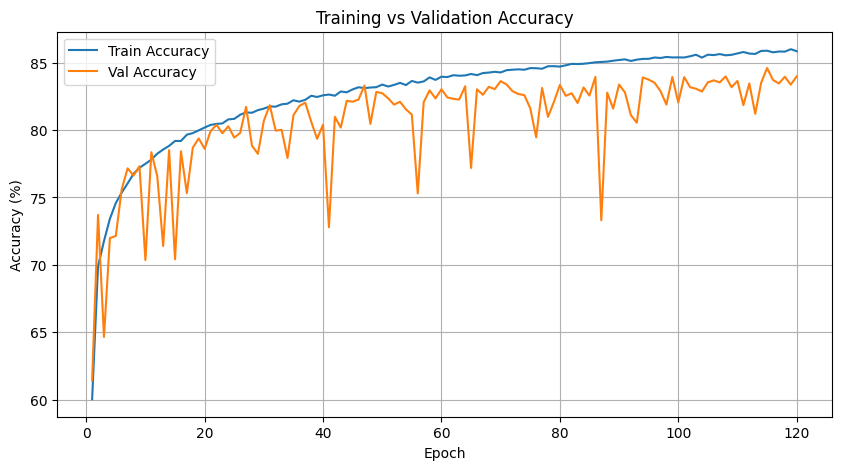

In [ ]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'output/{output_path}/diagram/accuracy_plot.png')
plt.show()

#### Plot Loss and Plot Akurasi dari log csv

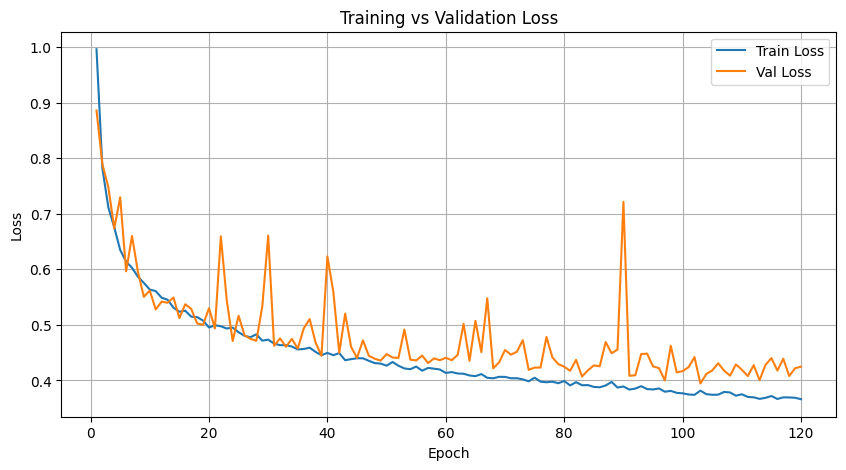

In [ ]:
# Ganti dengan path ke file CSV kamu jika file sudah disimpan
csv_file = f'output/{output_path}/logs/trainlog.csv'

# Membaca file CSV
df = pd.read_csv(csv_file)

# Ekstrak data
num_epochs = len(df)
train_losses = df['Train Loss']
val_losses = df['Val Loss']
train_accuracies = df['Train Accuracy']
val_accuracies = df['Val Accuracy']

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'output/{output_path}/diagram/loss_plot.png')
plt.show()


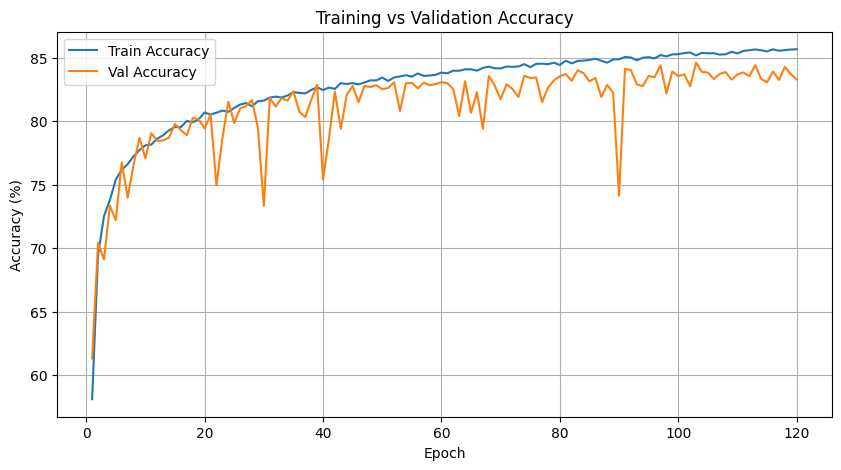

In [ ]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'output/{output_path}/diagram/accuracy_plot.png')
plt.show()